In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils
from string import digits
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.utils import plot_model
from keras.layers import Embedding, SpatialDropout1D, LSTM, BatchNormalization, Dropout, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from nltk.corpus import stopwords
import string
import nltk
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
token = RegexpTokenizer("[\w']+")
sw = stopwords.words('english')
words = set(nltk.corpus.words.words())

# Get data sets and preprocessing fuctions

In [4]:
def get_datasets():
    columnLabels = ['country', 'id', 'title', 'c1', 'c2', 'c3', 'description', 'price', 'type']
    train = pd.read_csv("/content/drive/My Drive/Semester 6 (CS)/IR/PROJECT/product title classification/data_train.csv", names=columnLabels)
    test = pd.read_csv("/content/drive/My Drive/Semester 6 (CS)/IR/PROJECT/product title classification/data_valid.csv", names=columnLabels)
    return train, test


def preprocess_df(dataframe):
    df = pd.DataFrame()
    #tokenize and convert to lower case
    dataframe['title'] = dataframe['title'].apply(lambda x: token.tokenize(x.lower()) if isinstance(x, str) else x)
    #stopword removal
    dataframe['title'] = dataframe['title'].apply(lambda x: ' '.join([w for w in x if w not in sw]) if isinstance(x, str) else x)
    #remove punctuations and other symbols
    dataframe['title'] = dataframe['title'].apply(lambda x: [w for w in nltk.wordpunct_tokenize(x)\
                                                             if w is not w.isalpha() and not w.isnumeric()] if isinstance(x, str) else x)
    #remove digits
    dataframe['title'] = dataframe['title'].apply(lambda x: [w.translate({ord(k): None for k in digits}) for w in x] if isinstance(x, str) else x)
    #remove single length words
    dataframe['title'] = dataframe['title'].apply(lambda x: ' '.join([w for w in x if len(w)>1]) if isinstance(x, str) else x)

    df['title'] = dataframe['title'].values

    df['c1'] = dataframe['c1'].values
    df['c2'] = dataframe['c2'].values
    df['c3'] = dataframe['c3'].values
    df['c3'] = df['c3'].replace(np.nan, 'none', regex=True)

    return df

Axes(0.125,0.11;0.775x0.77)


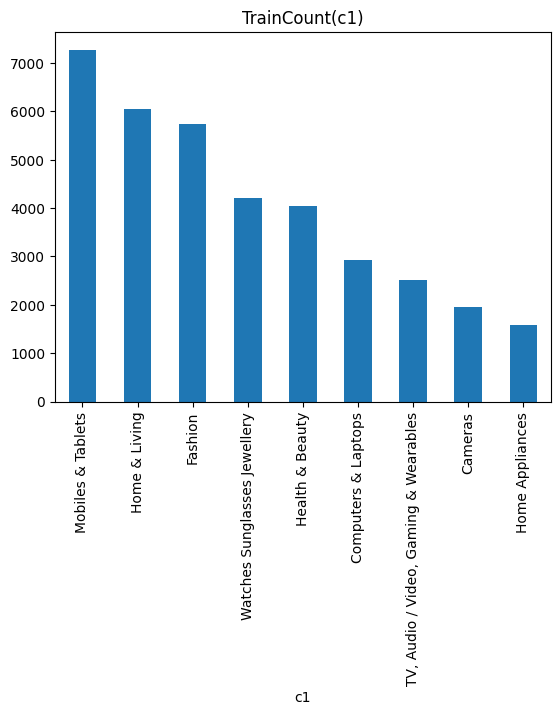

In [5]:
train_df, test_df = get_datasets()
tCol_df = preprocess_df(train_df)
tCol_df_test = preprocess_df(test_df)
# print("Length of train_df:", len(train_df))
# print("Length of test_df:", len(test_df))

# print("First few rows of train_df:")
# print(train_df.head())

# print("First few rows of test_df:")
# print(test_df.head())

print(train_df.c1.value_counts().plot(kind = 'bar', title = 'TrainCount(c1)'))

In [6]:
# tCol_df_test

# Create padded input sequences

In [7]:
maxWords = 20000
MaxWordLength = 50
tokenizer = Tokenizer(num_words = maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(tCol_df['title'].values)

### Train input data sequences

In [8]:
train_X_c1 = tokenizer.texts_to_sequences((tCol_df['title']).values )
train_X_c1 = tf.keras.preprocessing.sequence.pad_sequences(train_X_c1, maxlen=MaxWordLength)

print('Shape of data tensor:', train_X_c1.shape)

x = tCol_df['title'].astype(str) + ' ' + tCol_df['c1'].astype(str)
train_X_c2 = tokenizer.texts_to_sequences((x).values )
train_X_c2 = tf.keras.preprocessing.sequence.pad_sequences(train_X_c2, maxlen=MaxWordLength)

print('Shape of data tensor:', train_X_c2.shape)

x=tCol_df['title'].astype(str)+' '+tCol_df['c1'].astype(str)+' '+tCol_df['c2'].astype(str)
train_X_c3 = tokenizer.texts_to_sequences((x).values )
train_X_c3 = tf.keras.preprocessing.sequence.pad_sequences(train_X_c3, maxlen=MaxWordLength)

print('Shape of data tensor:', train_X_c3.shape)

Shape of data tensor: (36283, 50)
Shape of data tensor: (36283, 50)
Shape of data tensor: (36283, 50)


### Test input data sequences

In [9]:
test_X_c1 = tokenizer.texts_to_sequences((tCol_df_test['title']).values)
test_X_c1 = tf.keras.preprocessing.sequence.pad_sequences(test_X_c1, maxlen=MaxWordLength)

print('Shape of test data tensor:', test_X_c1.shape)

x=tCol_df_test['title'].astype(str)+' '+tCol_df_test['c1'].astype(str)
test_X_c2 = tokenizer.texts_to_sequences((x).values)
test_X_c2 = tf.keras.preprocessing.sequence.pad_sequences(test_X_c2, maxlen=MaxWordLength)

print('Shape of test data tensor:', test_X_c2.shape)

x=tCol_df_test['title'].astype(str)+' '+tCol_df_test['c1'].astype(str)+' '+tCol_df_test['c2'].astype(str)
test_X_c3 = tokenizer.texts_to_sequences((x).values)
test_X_c3 = tf.keras.preprocessing.sequence.pad_sequences(test_X_c3, maxlen=MaxWordLength)

print('Shape of test data tensor:', test_X_c3.shape)


Shape of test data tensor: (11838, 50)
Shape of test data tensor: (11838, 50)
Shape of test data tensor: (11838, 50)


# Y-label Encoding

## Train label encoding

In [10]:
# @title
train_Y_c1 = pd.get_dummies(tCol_df['c1']).values # one hot encoding
print('Shape of label tensor:', train_Y_c1.shape)

train_Y_c2 = pd.get_dummies(tCol_df['c2']).values # one hot encoding
print('Shape of label tensor:', train_Y_c2.shape)

train_Y_c3 = pd.get_dummies(tCol_df['c3']).values # one hot encoding
print('Shape of label tensor:', train_Y_c3.shape)



Shape of label tensor: (36283, 9)
Shape of label tensor: (36283, 57)
Shape of label tensor: (36283, 185)


## Test label encoding

In [11]:
# @title
test_Y_c1 = pd.get_dummies(tCol_df_test['c1']).values
print('Shape of test label tensor:', test_Y_c1.shape)

test_Y_c2 = pd.get_dummies(tCol_df_test['c2']).values
print('Shape of test label tensor:', test_Y_c2.shape)

test_Y_c3 = pd.get_dummies(tCol_df_test['c3']).values
print('Shape of test label tensor:', test_Y_c3.shape)

Shape of test label tensor: (11838, 9)
Shape of test label tensor: (11838, 57)
Shape of test label tensor: (11838, 185)


In [12]:
# @title
#print label decoding sequence

labels_c1=sorted(tCol_df['c1'].unique())
print(labels_c1)

labels_c2=sorted(tCol_df['c2'].unique())
print(labels_c2)

labels_c3=sorted(tCol_df['c3'].unique())
print(labels_c3)


['Cameras', 'Computers & Laptops', 'Fashion', 'Health & Beauty', 'Home & Living', 'Home Appliances', 'Mobiles & Tablets', 'TV, Audio / Video, Gaming & Wearables', 'Watches Sunglasses Jewellery']
['Accessories', 'Audio', 'Bath', 'Bath & Body', 'Beauty Tools', 'Bedding', 'Boys', 'Camera Accessories', 'Computer Accessories', 'Computer Components', 'Cooling & Heating', 'DSLR', 'Desktops Computers', 'Drones', 'Eyewear', 'Food Supplements', 'Fragrances', 'Furniture', 'Gadgets', 'Gadgets & Other Cameras', 'Gaming', 'Garment Care', 'Girls', 'Hair Care', 'Home Décor', 'Home Improvement', 'Housekeeping', 'Jewellery', 'Kitchen & Dining', 'Laptops', 'Large Appliances', 'Lenses', 'Lighting', 'Makeup', 'Medical Supplies', 'Men', "Men's Care", 'Mirrorless', 'Mobiles', 'Network Components', 'Outdoor & Garden', 'Personal Care', 'Point & Shoot', 'Printers & Accessories', 'Skin Care', 'Small Kitchen Appliances', 'Stationery', 'Storage', 'Storage & Organisation', 'TV Accessories', 'Tablets', 'Televisions'

# Create NN Architecture and Train Model - Category1

In [13]:
# c1_count=tCol_df['c1'].nunique()
# print(c1_count)
# embeddingDimensions = 100
# model_c1 = Sequential()
# model_c1.add(Embedding(maxWords, embeddingDimensions, input_length = train_X_c1.shape[1]))
# model_c1.add(LSTM(512, dropout=0.4, recurrent_dropout = 0.2))
# model_c1.add(Dense(128, activation='relu'))
# model_c1.add(Dense(c1_count, activation = 'softmax'))
# model_c1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model_c1.summary()

# epochs = 15
# batch_size = 64

# history1 = model_c1.fit(train_X_c1, train_Y_c1,
#                     validation_data=(test_X_c1, test_Y_c1),
#                     epochs = epochs, batch_size = batch_size,
#                     shuffle = True,
#                     # validation_split = 0.1,\
#                     callbacks = [EarlyStopping(monitor = 'val_accuracy', patience =3 , min_delta = 0.0001),
#                                  ModelCheckpoint('/content/drive/My Drive/product title classification/h_Models/model_c1/{val_accuracy:.3f}', save_weights_only=False)
#                     ]
#                     )

# Create NN Architecture and Train Model - Category2

In [14]:
# c2_count=tCol_df['c2'].nunique()
# print(c2_count)
# embeddingDimensions = 100
# model_c2 = Sequential()
# model_c2.add(Embedding(maxWords, embeddingDimensions, input_length = train_X_c2.shape[1]))
# model_c2.add(LSTM(512, dropout=0.4, recurrent_dropout = 0.2))
# model_c2.add(Dense(128, activation='relu'))
# model_c2.add(Dense(c2_count, activation = 'softmax'))
# model_c2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model_c2.summary()

# epochs = 15
# batch_size = 64

# history2 = model_c2.fit(train_X_c2, train_Y_c2,
#                     validation_data=(test_X_c2, test_Y_c2),
#                     epochs = epochs, batch_size = batch_size,
#                     shuffle = True,
#                     # validation_split = 0.1,\
#                     callbacks = [EarlyStopping(monitor = 'val_accuracy', patience =3 , min_delta = 0.0001),
#                                  ModelCheckpoint('/content/drive/My Drive/product title classification/h_Models/model_c2/{val_accuracy:.3f}', save_weights_only=False)
#                     ]
#                     )

# Create NN Architecture and Train Model - Category3

In [15]:
# c3_count=tCol_df['c3'].nunique()
# print(c3_count)

# embeddingDimensions = 100
# model_c3 = Sequential()
# model_c3.add(Embedding(maxWords, embeddingDimensions, input_length = train_X_c3.shape[1]))
# model_c3.add(LSTM(512, dropout=0.4, recurrent_dropout = 0.2))
# model_c3.add(Dense(256, activation='relu'))
# model_c3.add(Dense(c3_count, activation = 'softmax'))
# model_c3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model_c3.summary()

# epochs = 15
# batch_size = 64

# history3 = model_c3.fit(train_X_c3, train_Y_c3,
#                     validation_data=(test_X_c3, test_Y_c3),
#                     epochs = epochs, batch_size = batch_size,
#                     shuffle = True,
#                     # validation_split = 0.1,\
#                     callbacks = [EarlyStopping(monitor = 'val_accuracy', patience =3 , min_delta = 0.0001),
#                                  ModelCheckpoint('/content/drive/My Drive/product title classification/h_Models/model_c3/{val_accuracy:.3f}', save_weights_only=False)
#                     ]
#                     )

In [16]:
# accs=history1.history['accuracy']
# val_accs=history1.history['val_accuracy']
# plt.title('ACCURACY (on different runs)')
# plt.plot(range(len(accs)), accs, label='Training')
# plt.plot(range(len(accs)), val_accs, label='Validation')
# plt.legend()
# plt.show()

In [17]:
# accs=history2.history['accuracy']
# val_accs=history2.history['val_accuracy']
# plt.title('ACCURACY (on different runs)')
# plt.plot(range(len(accs)), accs, label='Training')
# plt.plot(range(len(accs)), val_accs, label='Validation')
# plt.legend()
# plt.show()

In [18]:
# accs=history3.history['accuracy']
# val_accs=history3.history['val_accuracy']
# plt.title('ACCURACY (on different runs)')
# plt.plot(range(len(accs)), accs, label='Training')
# plt.plot(range(len(accs)), val_accs, label='Validation')
# plt.legend()
# plt.show()

In [19]:
import glob
import os
l = glob.glob('/content/drive/My Drive/product title classification/h_Models/model_c1/*')
l = [format(float(os.path.basename(x)), '.3f') for x in l]
print(l)
m1 = max(l)
m1

['0.908', '0.921', '0.917']


'0.921'

In [20]:
l = glob.glob('/content/drive/My Drive/product title classification/h_Models/model_c2/*')
l = [format(float(os.path.basename(x)), '.3f') for x in l]
print(l)
m2 = max(l)
m2

['0.538', '0.542', '0.543', '0.544', '0.539', '0.546', '0.547']


'0.547'

In [21]:
l = glob.glob('/content/drive/My Drive/product title classification/h_Models/model_c3/*')
l = [format(float(os.path.basename(x)), '.3f') for x in l]
print(l)
m3 = max(l)
m3

['0.446', '0.444', '0.455', '0.460', '0.459', '0.458', '0.449']


'0.460'

# Load Model

In [22]:
model_c1=tf.keras.models.load_model('/content/drive/My Drive/product title classification/h_Models/model_c1/{}'.format(m1))

In [23]:
model_c2=tf.keras.models.load_model('/content/drive/My Drive/product title classification/h_Models/model_c2/{}'.format(m2))

In [24]:
model_c3=tf.keras.models.load_model('/content/drive/My Drive/product title classification/h_Models/model_c3/{}'.format(m3))

# Prediction on test set

In [25]:
# ynew_c1 = model_c1.predict_classes(test_X_c1)
ynew_c1 = (model_c1.predict(test_X_c1) > 0.5).astype("int32")

370/370 [==============================] - 89s 240ms/step


In [26]:
# ynew_c2 = model_c2.predict_classes(test_X_c2)
ynew_c2 = (model_c2.predict(test_X_c2) > 0.5).astype("int32")

370/370 [==============================] - 87s 234ms/step


In [27]:
# ynew_c3 = model_c3.predict_classes(test_X_c3)
ynew_c3 = (model_c3.predict(test_X_c3) > 0.5).astype("int32")

370/370 [==============================] - 86s 232ms/step


In [28]:
# # show the inputs and predicted outputs
# for i in range(len(test_X_c1)):
# 	print("%d --> X=%s, --> Predicted=%s, Actual=%s" % (i, tCol_df_test['title'][i], labels_c1[ynew_c1[i]], tCol_df_test['c1'][i]))

# convert probabilities to class labels
ynew_c1 = np.argmax(ynew_c1, axis=1)

for i in range(len(test_X_c1)):
    print("%d --> X=%s, --> Predicted=%s, Actual=%s" % (i, tCol_df_test['title'][i], labels_c1[ynew_c1[i]], tCol_df_test['c1'][i]))


Streaming output truncated to the last 5000 lines.
6838 --> X=['women', 'fashion', 'leather', 'wallet', 'purse', 'blue'], --> Predicted=Fashion, Actual=Fashion
6839 --> X=['penshoppe', 'hi', 'low', 'crewneck', 'tee', 'with', 'taping', 'white'], --> Predicted=Fashion, Actual=Fashion
6840 --> X=['remax', 'alien', '1m', 'lightning', 'usb', 'cable', 'blue'], --> Predicted=Mobiles & Tablets, Actual=Mobiles & Tablets
6841 --> X=['samsung', '40', 'led', 'tv', 'black', 'ua40j5100'], --> Predicted=TV, Audio / Video, Gaming & Wearables, Actual=TV, Audio / Video, Gaming & Wearables
6842 --> X=['samsung', 'rl', '4013ubasl', '2', 'door', 'bottom', 'freezer', 'refrigerator', '14', '8cu', 'ft'], --> Predicted=Home Appliances, Actual=Home Appliances
6843 --> X=['memory', 'foam', 'travel', 'neck', 'pillow', 'red', 'buy', '1', 'take', '1'], --> Predicted=Home & Living, Actual=Home & Living
6844 --> X=['chuwi', 'hi10', 'plus', 'dual', 'os', 'tablet', 'pc', '2', 'in', '1s', 'hdmi', '1920x1280', 'windows',

# Title Prediction on real time example

In [ ]:
# # from IPython.display import HTML, display
# # from ipywidgets import widgets
# # import tensorflow as tf
# # import numpy as np

# # # Function to preprocess text and make predictions
# # def preprocess_and_predict(title):
# #     new_x = [title]
# #     seq = tokenizer.texts_to_sequences(new_x)
# #     padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# #     pred1 = model_c1.predict(padded)
# #     category1 = labels_c1[np.argmax(pred1)]
# #     new_x[0] = new_x[0] + ' ' + category1

# #     seq = tokenizer.texts_to_sequences(new_x)
# #     padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# #     pred2 = model_c2.predict(padded)
# #     category2 = labels_c2[np.argmax(pred2)]
# #     new_x[0] = new_x[0] + ' ' + category2

# #     seq = tokenizer.texts_to_sequences(new_x)
# #     padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# #     pred3 = model_c3.predict(padded)
# #     category3 = labels_c3[np.argmax(pred3)]

# #     return category1, category2, category3

# # # Function to handle prediction button click
# # def predict_button_click(b):
# #     title = text_input.value
# #     if title:
# #         category1, category2, category3 = preprocess_and_predict(title)
# #         # Updated to include the container style for the predicted categories
# #         output_label.value = f"<div style='{container_style}'><b>Predicted Categories:</b><br>{category1}<br>{category2}<br>{category3}</div>"

# # # Function to clear the output
# # def clear_output_click(b):
# #     output_label.value = ""

# # # Create a clear button
# # clear_button = widgets.Button(description="Clear Output")

# # # Style the clear button
# # clear_button.style.button_color = "#4CAF50";
# # clear_button.style.font_weight = 'bold'

# # # Set the layout for the clear button
# # clear_button.layout = widgets.Layout(width='max-content', margin='20px auto')

# # # Assign the event handler function to the clear button
# # clear_button.on_click(clear_output_click)

# # # Update button style
# # predict_button.style.button_color = '#4CAF50'

# # # Styling for text
# # def styled_text(text, style=''):
# #     return f"<span style='{style}'>{text}</span>"

# # # Define styles
# # container_style = "background-color: #f2f2f2; padding: 20px;"
# # title_style = "font-size: 24px; font-weight: bold; color: #4CAF50; text-align: center;"
# # name_style1 = "font-size: 18px; font-weight: bold; color: #FFC107; text-align: center;"
# # name_style2 = "font-size: 18px; font-weight: bold; color: #FF5722; text-align: center;"
# # button_style = 'background-color:#4CAF50;color:white;padding:14px 20px;margin-left:auto;margin-right:auto;display:block;width:max-content;border:none;border-radius:.25rem;font-size:.875rem'

# # # Display styled text with updated styles
# # display((HTML(styled_text("<div style='" + container_style + "'>IR PROJECT</div>", style=title_style))))
# # display((HTML(styled_text("<div style='" + container_style + "'>Team:</div>", style=name_style1))))
# # display((HTML(styled_text("<div style='" + container_style + "'>Muhammad Tahir</div>", style=name_style2))))
# # display((HTML(styled_text("<div style='" + container_style + "'>Insha Javed</div>", style=name_style2))))

# # # Center aligning the text input and output label
# # text_input.layout = widgets.Layout(width='50%', margin='0 auto')
# # output_label.layout = widgets.Layout(width='50%', margin='0 auto')

# # # Center aligning the predict button and increasing its size
# # predict_button.layout = widgets.Layout(width='max-content', margin='20px auto')
# # predict_button.style.font_weight = 'bold'

# # # Center aligning the clear button
# # clear_button.layout = widgets.Layout(width='max-content', margin='20px auto')
# # clear_button.style.font_weight = 'bold'

# # display(text_input)
# # display(predict_button)
# # display(clear_button)
# # display(output_label)

# new_x=[]

# x = str(input("Enter the product title : "))

# # title preprocessing
# new_x.append(x)
# seq = tokenizer.texts_to_sequences(new_x)
# padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# # c1 prediction
# pred1 = model_c1.predict(padded)
# print('Category 1: ',labels_c1[np.argmax(pred1)])

# # concatenate title + c1
# new_x[0]=new_x[0]+' '+labels_c1[np.argmax(pred1)]

# # title + c1 preprocessing
# seq = tokenizer.texts_to_sequences(new_x)
# padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# # c2 prediction
# pred2 = model_c2.predict(padded)
# print('Category 2: ',labels_c2[np.argmax(pred2)])

# # concatenate title + c1 + c2
# new_x[0]=new_x[0]+' '+labels_c2[np.argmax(pred2)]

# # title + c1 + c2 preprocessing
# seq = tokenizer.texts_to_sequences(new_x)
# padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# # c3 prediction
# pred3 = model_c3.predict(padded)
# print('Category 3: ',labels_c3[np.argmax(pred3)])


# # pred[0][np.argmax(pred)

In [35]:



new_x=[]

x = str(input("Enter the product title : "))

# title preprocessing
new_x.append(x)
seq = tokenizer.texts_to_sequences(new_x)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# c1 prediction
pred1 = model_c1.predict(padded)
print('Category 1: ',labels_c1[np.argmax(pred1)])

# concatenate title + c1
new_x[0]=new_x[0]+' '+labels_c1[np.argmax(pred1)]

# title + c1 preprocessing
seq = tokenizer.texts_to_sequences(new_x)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# c2 prediction
pred2 = model_c2.predict(padded)
print('Category 2: ',labels_c2[np.argmax(pred2)])

# concatenate title + c1 + c2
new_x[0]=new_x[0]+' '+labels_c2[np.argmax(pred2)]

# title + c1 + c2 preprocessing
seq = tokenizer.texts_to_sequences(new_x)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# c3 prediction
pred3 = model_c3.predict(padded)
print('Category 3: ',labels_c3[np.argmax(pred3)])


# pred[0][np.argmax(pred)

Enter the product title : Polk Audio Blackstone TL1600 Compact Home Theater Speaker System
1/1 [==============================] - 0s 104ms/step
Category 1:  TV, Audio / Video, Gaming & Wearables
1/1 [==============================] - 0s 97ms/step
Category 2:  Audio
1/1 [==============================] - 0s 104ms/step
Category 3:  Headphones & Headsets


# Model Evaluation

In [31]:
acc = model_c1.evaluate(test_X_c1, test_Y_c1)
ModelAccuracy1 = acc[1]
print('ModelAccuracy for c1 =',round(acc[1],2)*100,'%')
model_c1.summary()

370/370 [==============================] - 84s 225ms/step - loss: 0.3083 - accuracy: 0.9205
ModelAccuracy for c1 = 92.0 %
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2000000   
                                                                 
 lstm (LSTM)                 (None, 512)               1255424   
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 3322249 (12.67 MB)
Trainable params: 3322249 (12.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
acc = model_c2.evaluate(test_X_c2, test_Y_c2)
ModelAccuracy2 = acc[1]
print('ModelAccuracy for c2 =',round(acc[1],2)*100,'%')
model_c2.summary()

370/370 [==============================] - 85s 228ms/step - loss: 1.2267 - accuracy: 0.5471
ModelAccuracy for c2 = 55.00000000000001 %
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 lstm_1 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 57)                7353      
                                                                 
Total params: 3328441 (12.70 MB)
Trainable params: 3328441 (12.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
acc = model_c3.evaluate(test_X_c3, test_Y_c3)
ModelAccuracy3 = acc[1]
print('ModelAccuracy for c3 =',round(acc[1],2)*100,'%')
model_c3.summary()

## Overall Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
Overall_accuracy = ((ModelAccuracy1+ModelAccuracy2+ModelAccuracy3)/3)*100
print("Overall Model accuracy is: ", round(Overall_accuracy,3),'%')

In [ ]:
def y_conversion(y_onehot):
    y_labels=[]
    # print(y_onehot[0:15])
    for i in y_onehot:
        y_labels.append(np.argmax(i))
    y_labels = np.asarray(y_labels)
    # print(type(y_labels[0:15]), y_labels[0:15])

    return y_labels

# Convert predicted labels
ynew_c1 = y_conversion(ynew_c1)
ynew_c2 = y_conversion(ynew_c2)
ynew_c3 = y_conversion(ynew_c3)

y1 = y_conversion(test_Y_c1)
accuracy = accuracy_score(y1, ynew_c1)
print("\n----------for category 1----------")
print('Accuracy: %f' % accuracy)
kappa = cohen_kappa_score(y1, ynew_c1)
print('Cohens kappa: %f' % kappa)

print("\n----------for category 2----------")
y2 = y_conversion(test_Y_c2)
accuracy = accuracy_score(y2, ynew_c2)
print('Accuracy: %f' % accuracy)
kappa = cohen_kappa_score(y2, ynew_c2)
print('Cohens kappa: %f' % kappa)

print("\n----------for category 3----------")
y3 = y_conversion(test_Y_c3)
accuracy = accuracy_score(y3, ynew_c3)
print('Accuracy: %f' % accuracy)
kappa = cohen_kappa_score(y3, ynew_c3)
print('Cohens kappa: %f' % kappa)

In [ ]:
# # accuracy: (tp + tn) / (p + n)
# print(test_Y_c1[0], ynew_c1[0])

# # oh_yp1=pd.get_dummies(ynew_c1).values
# # print("test\n",test_Y_c1,oh_yp1)
# # m = tf.keras.metrics.Recall()
# # m.update_state(test_Y_c1, ynew_c1)
# # m.result().numpy()

# # accuracy = accuracy_score(y1, ynew_c1)
# # print('Accuracy: %f' % accuracy)
# # precision tp / (tp + fp)
# # precision = precision_score(y1, ynew_c1, average=None)
# # print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
# # recall = recall_score(y1, ynew_c1)
# # print('Recall: %f' % recall)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(y1, ynew_c1, average='weighted')
# print('F1 score: %f' % f1)


# # confusion matrix
# matrix = confusion_matrix(test_Y_c1, oh_yp1)
# print(matrix)

# Loaded Model Architectures

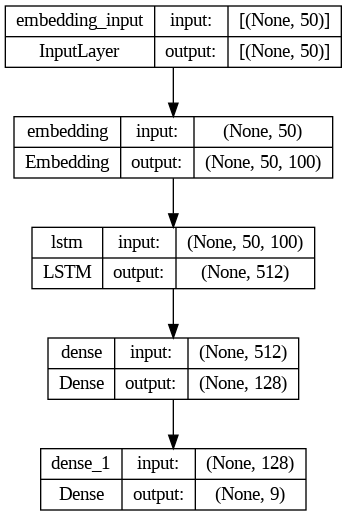

In [37]:
plot_model(model_c1, show_shapes=True)

In [ ]:
plot_model(model_c2, show_shapes=True)

In [ ]:
plot_model(model_c3, show_shapes=True)